## Data Analysis
This notebook will be used to analyse data from Combination Lock experiments.

### Install Libraries

In [133]:
%%capture

%pip install matplotlib
%pip install scipy
import json
import glob
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
%matplotlib inline
import matplotlib as mpl


### Read in Files

In [134]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])

### Extract Data Across Participants into Single Dict

In [135]:
fullDict = {}


for f in files:
    fullDict = fullDict | f

print(len(fullDict))

42


### Traverse entire dataset, adding each list to the appropraite method list

In [136]:
methodsDict = {'tap6':[], 'tap10':[], 'direction6':[], 'direction10':[], 'pin':[],'pattern':[]}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif  method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]
    
# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(filter(lambda x:x['endState'] != 'ABORTED', methodsDict[key]))

### Graph Average Success Rate For Each Method

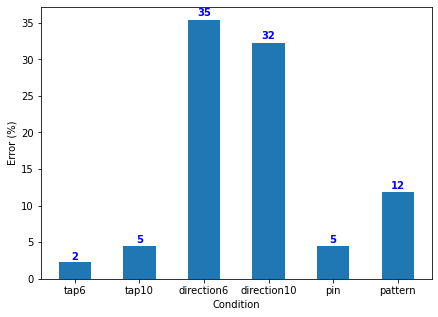

In [137]:
successRates = {}

def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100

for method in methodsDict:
    successRates[method] = computeErrorRate(methodsDict[method])


fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

x = list(successRates.keys())
y = list(successRates.values())


rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom' , color='blue', fontweight='bold')

### Graph Average Authentication Time for Successful Sessions

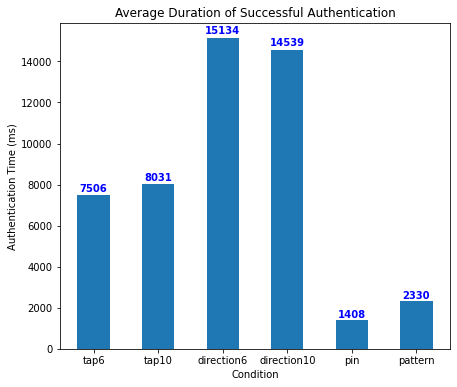

In [138]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState']=='SUCCESS', lst))
    total = 0
    for val in lst:
        total+= val['elapsedTimeInMilliseconds']
    return total/len(successfulAuths)

for method in methodsDict:
    successRates[method] = computeAverageSuccessTime(methodsDict[method])

fig, ax = plt.subplots(figsize=(7,6))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(successRates.keys())
y = list(successRates.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom', color='blue', fontweight='bold')

### Time Distribution

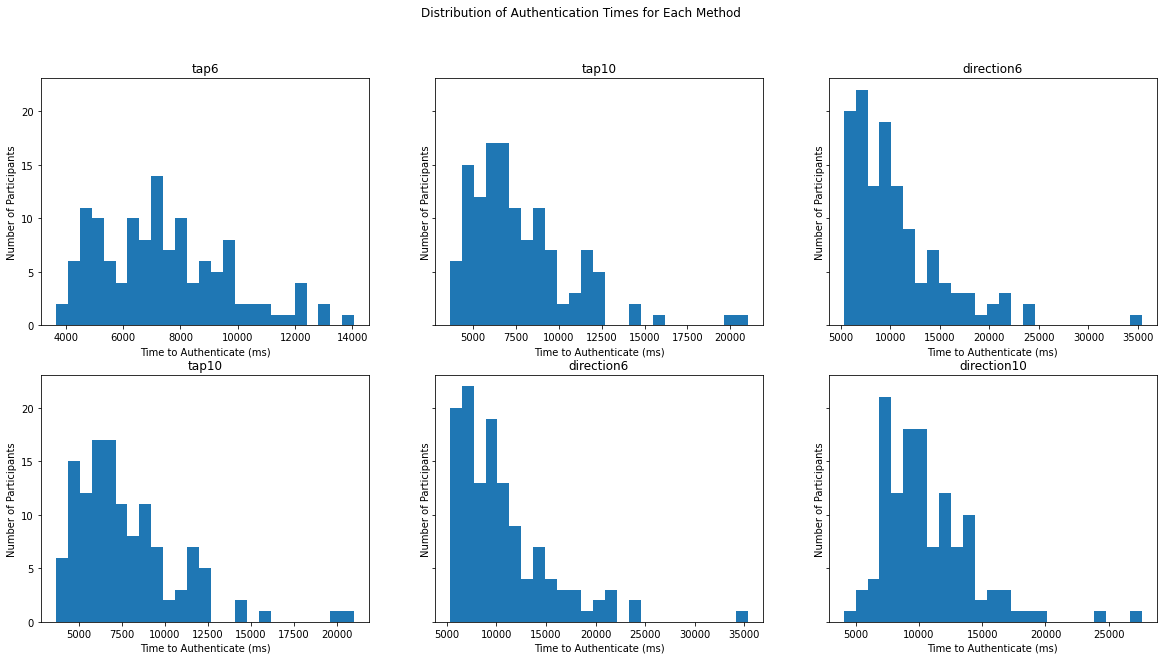

In [142]:
successfulAuths = methodsDict.copy()

for item in successfulAuths:
    successfulAuths[item] = list(filter(lambda x: x['endState']=='SUCCESS', allAuths[item]))
successfulAuthsTimeList = list(map(lambda x: {x:list(map(lambda y: y['elapsedTimeInMilliseconds'],successfulAuths[x]))}, successfulAuths))

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20,10))
fig.suptitle('Distribution of Authentication Times for Each Method')

n_bins = 25


for i in range(0,2):
    for j in range(0,3):
        axs[i,j].hist(successfulAuthsTimeList[i+j].values(), bins=n_bins)
        axs[i,j].set_title(list(successfulAuthsTimeList[i+j].keys())[0])
        axs[i,j].set_xlabel('Time to Authenticate (ms)')
        axs[i,j].set_ylabel('Number of Participants')


### Statistical Tests - One-Way ANOVA

In [151]:
anovaSuccessTimeSamples = list(map(lambda x: list(x.values())[0], successfulAuthsTimeList))

errors = {}
for method in methodsDict:
    for auth in methodsDict[method]:
        if auth['endState'] == 'FAILURE':
            errors[method] = errors.get(method, 0) + 1

f_stat_authTime = f_oneway(*anovaSuccessTimeSamples)


print(f'ANOV?A: Number of Errors\nF-statistic: {f_stat_authTime.statistic}\np-value:{f_stat_authTime.pvalue}')
print(f'ANOVA: Successful Authentication Times\nF-statistic: {f_stat_authTime.statistic}\np-value:{f_stat_authTime.pvalue}')

TypeError: 'int' object is not iterable

In [168]:

for f in files:
    fileToErrorCounts(f)

# Given a file, return a dictionary with the number of errors for each method
def fileToErrorCounts(file):
    counts = {'tap6':0, 'tap10':0, 'direction6':0, 'direction10':0, 'pin':0,'pattern':0}
    fullList = []

    for val in list(file.values()):
        fullList += val
    
    for auth in fullList:
        if auth['endState'] == 'FAILURE':
            if auth['method'] == 'tap':
                if auth['numTicks'] == '6':
                    counts['tap6'] += 1
                else:
                    counts['tap10'] += 1
            elif  auth['method'] == 'direction':
                if auth['numTicks'] == '6':
                    counts['direction6'] += 1
                else:
                    counts['direction10'] += 1
            elif auth['method'] == 'PATTERN':
                counts['pattern'] += 1
            elif auth['method'] == 'PIN':
                counts['pin'] += 1

    print(counts)

{'userPassword': [0, 2, 3, 4], 'enteredPassword': [0, 2, 2, 3], 'startTime': 1646853357609, 'endTime': 1646853362263, 'elapsedTimeInMilliseconds': 4654, 'method': 'tap', 'numTicks': '6', 'endState': 'FAILURE'}
{'userPassword': [0, 2, 3, 4], 'enteredPassword': [0, 3, 4, 3], 'startTime': 1646853854165, 'endTime': 1646853866900, 'elapsedTimeInMilliseconds': 12735, 'method': 'direction', 'numTicks': '6', 'endState': 'FAILURE'}
{'userPassword': [0, 2, 3, 4], 'enteredPassword': [5, 2, 0, 2], 'startTime': 1646853870456, 'endTime': 1646853876065, 'elapsedTimeInMilliseconds': 5609, 'method': 'direction', 'numTicks': '6', 'endState': 'FAILURE'}
{'userPassword': [1, 5, 4, 1], 'enteredPassword': [1, 5, 4, 2], 'startTime': 1646853926957, 'endTime': 1646853938006, 'elapsedTimeInMilliseconds': 11049, 'method': 'direction', 'numTicks': '6', 'endState': 'FAILURE'}
{'userPassword': [4, 3, 4, 5], 'enteredPassword': [3, 5, 2, 4], 'startTime': 1646853975619, 'endTime': 1646853980113, 'elapsedTimeInMillisec